In [ ]:
import os
import argparse
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import itertools

## CONFIG

In [ ]:
BASE_DIR = Path(".").resolve()
DATASET_DIR = BASE_DIR / "dataset" 
OUTPUT_DIR = BASE_DIR / "reports"
MODELS_DIR = BASE_DIR / "models"

IMG_SIZE = (128, 128)
BATCH_SIZE = 16
EPOCHS = 2

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
def create_data_generators(data_dir, img_size=IMG_SIZE, batch_size=BATCH_SIZE):
    data_gen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        validation_split=0.2,
        rotation_range=15,
        zoom_range=0.1,
        horizontal_flip=True,
    )

    train_data = data_gen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        subset="training",
        shuffle=True,
    )

    val_data = data_gen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        subset="validation",
        shuffle=True,
    )

    test_gen = ImageDataGenerator(rescale=1.0 / 255.0)
    test_data = test_gen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=1,
        shuffle=False,
    )

    return train_data, val_data, test_data


def show_sample_images(train_data, class_names, save_path=None):

    x_batch, y_batch = next(train_data)
    num_images = min(12, len(x_batch))

    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(3, 4, i + 1)
        plt.imshow(x_batch[i])
        plt.axis("off")
        label_idx = np.argmax(y_batch[i])
        plt.title(class_names[label_idx])

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
        print(f"Saved sample images to: {save_path}")
    plt.show()

In [ ]:
def build_cnn_model(img_size, num_classes):

    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(
                32, (3, 3), activation="relu", input_shape=img_size + (3,)
            ),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


def build_mobilenet_model(img_size, num_classes):

    base_model = tf.keras.applications.MobileNetV2(
        include_top=False,
        input_shape=img_size + (3,),
        weights="imagenet",
    )
    base_model.trainable = False  # freeze base

    inputs = tf.keras.Input(shape=img_size + (3,))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [ ]:
def plot_history(history, title_prefix, save_prefix=None):

    acc = history.history.get("accuracy", [])
    val_acc = history.history.get("val_accuracy", [])
    loss = history.history.get("loss", [])
    val_loss = history.history.get("val_loss", [])

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label="train")
    plt.plot(val_acc, label="val")
    plt.title(f"{title_prefix} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label="train")
    plt.plot(val_loss, label="val")
    plt.title(f"{title_prefix} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    if save_prefix is not None:
        acc_path = f"{save_prefix}_accuracy.png"
        plt.savefig(acc_path)
        print(f"Saved training curves to: {acc_path}")
    plt.show()


def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, save_path=None):

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=6,
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
        print(f"Saved confusion matrix to: {save_path}")
    plt.show()

def evaluate_model(model, test_data, class_names, save_prefix=None):

    y_true = test_data.classes
    y_prob = model.predict(test_data, verbose=1)
    y_pred = np.argmax(y_prob, axis=1)

    # Force labels to match the number of class_names
    labels = list(range(len(class_names)))

    report = classification_report(
        y_true,
        y_pred,
        labels=labels,
        target_names=class_names,
        digits=4,
        zero_division=0,   # avoid divide-by-zero warnings if some classes are missing
    )
    print(report)

    if save_prefix is not None:
        report_path = f"{save_prefix}_classification_report.txt"
        with open(report_path, "w", encoding="utf-8") as f:
            f.write(report)
        print(f"Saved classification report to: {report_path}")

        cm_path = f"{save_prefix}_confusion_matrix.png"
    else:
        cm_path = None

    plot_confusion_matrix(
        y_true,
        y_pred,
        classes=class_names,
        normalize=False,
        save_path=cm_path,
    )


In [ ]:
if not DATASET_DIR.exists():
    raise FileNotFoundError(f"Dataset directory not found: {DATASET_DIR}")

train_data, val_data, test_data = create_data_generators(
    str(DATASET_DIR),
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

class_names = list(train_data.class_indices.keys())
print("Classes:", class_names)

sample_path = OUTPUT_DIR / "sample_images.png"
show_sample_images(train_data, class_names, save_path=sample_path)


In [ ]:
print("Training baseline CNN model...")

cnn_model = build_cnn_model(IMG_SIZE, num_classes=len(class_names))
cnn_history = cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    steps_per_epoch=len(train_data) // 4,
    validation_steps=len(val_data) // 4,  
)

cnn_model_path = MODELS_DIR / "traffic_sign_cnn.h5"
cnn_model.save(cnn_model_path)
print(f"Saved CNN model to: {cnn_model_path}")

plot_history(
    cnn_history,
    title_prefix="CNN",
    save_prefix=str(OUTPUT_DIR / "cnn"),
)

41909/41909 [==============================] - 1522s 36ms/step
                                        precision    recall  f1-score   support

   annotations for mtsd in coco format     0.0000    0.0000    0.0000         0
     mtsd_fully_annotated_train_images     0.8731    1.0000    0.9322     36589
   mtsd_partially_annotated_annotation     0.0000    0.0000    0.0000         0
mtsd_v2_fully_annotated_annotation.zip     0.0000    0.0000    0.0000         0
mtsd_v2_fully_annotated_images.val.zip     0.0000    0.0000    0.0000      5320

                             micro avg     0.8731    0.8731    0.8731     41909
                             macro avg     0.1746    0.2000    0.1864     41909
                          weighted avg     0.7622    0.8731    0.8139     41909

Saved classification report to: E:\AAI\AAI521-ImageProcessing and NN\project\src\reports\cnn_classification_report.txt
Saved confusion matrix to: E:\AAI\AAI521-ImageProcessing and NN\project\src\reports\cnn_confusi

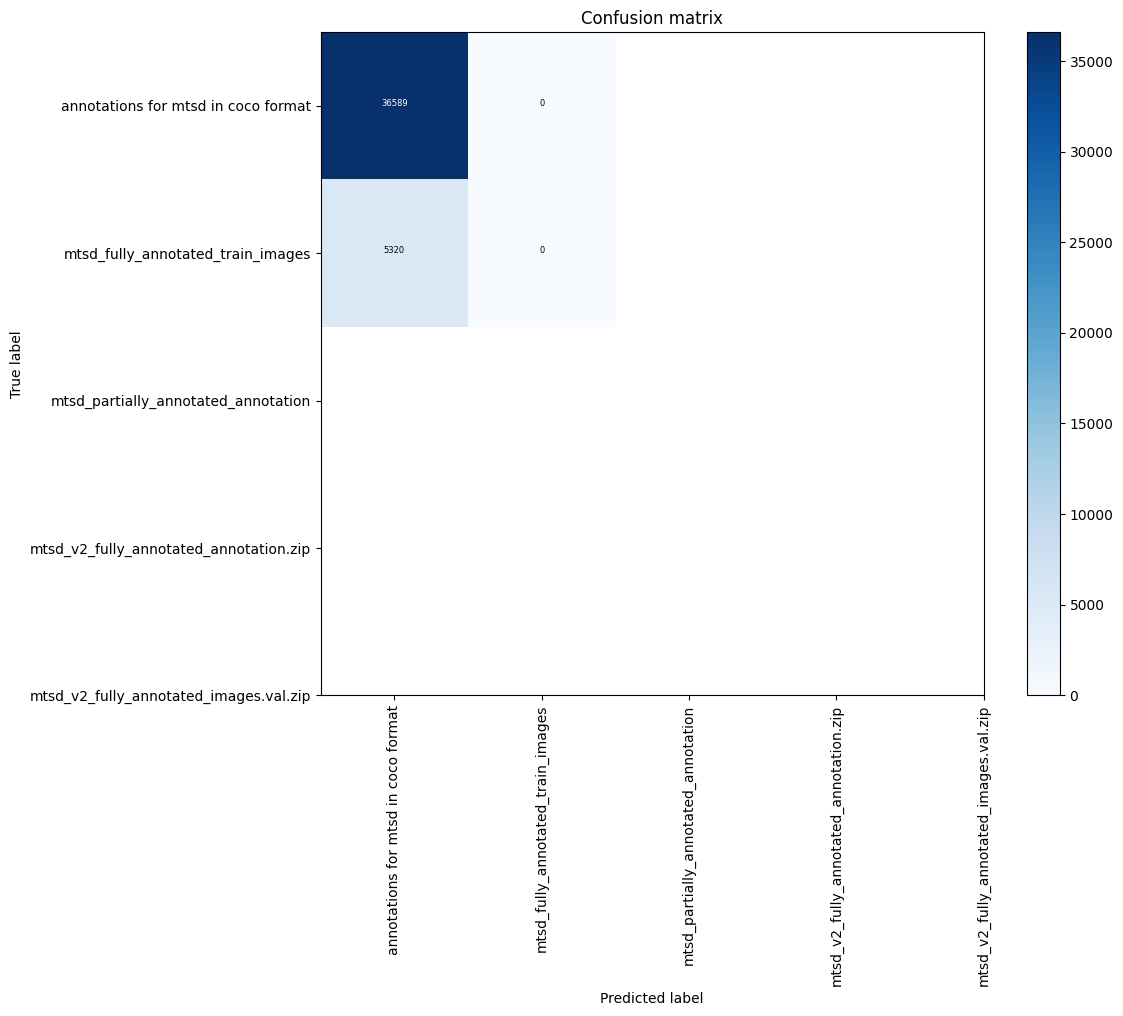

In [11]:
evaluate_model(
    cnn_model,
    test_data,
    class_names,
    save_prefix=str(OUTPUT_DIR / "cnn"),
)

In [ ]:
print("Training MobileNetV2 transfer learning model...")

mobilenet_model = build_mobilenet_model(
    IMG_SIZE,
    num_classes=len(class_names),
)
mobilenet_history = mobilenet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    steps_per_epoch=len(train_data) // 4,
    validation_steps=len(val_data) // 4,
)

mobilenet_model_path = MODELS_DIR / "traffic_sign_mobilenet.h5"
mobilenet_model.save(mobilenet_model_path)
print(f"Saved MobileNetV2 model to: {mobilenet_model_path}")

plot_history(
    mobilenet_history,
    title_prefix="MobileNetV2",
    save_prefix=str(OUTPUT_DIR / "mobilenet"),
)

evaluate_model(
    mobilenet_model,
    test_data,
    class_names,
    save_prefix=str(OUTPUT_DIR / "mobilenet"),
)
